In [1]:
# Dependencies
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt, patches
from utils.config import load_config_nb
from evaluation.policy_evaluation import evaluate_policy
from nocturne.envs.base_env import BaseEnv

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (6, 6)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'

### Helper functions

In [6]:
def step_through_scene(env, scene_name, use_expert_actions, use_av_only=True, max_steps=80, verbose=False):
    
    pos_arr = np.zeros((max_steps, 2))
    speed_arr = np.zeros((max_steps))
    heading_arr = np.zeros((max_steps))
    steering_arr = np.zeros(max_steps)
    action_acc = np.zeros(max_steps)
    action_ste = np.zeros(max_steps)

    # RESET
    obs_dict = env.reset(filename=scene_name, use_av_only=use_av_only)
    
    # TAKE VEHICLE
    veh_obj = env.controlled_vehicles[0]
    print(f'Controlling veh_id: {veh_obj.id}, is_av: {veh_obj.is_av} | init_speed: {veh_obj.speed}')

    for time_step in range(max_steps):
        
        action_dict = {}
        if use_expert_actions:
            expert_action = env.scenario.expert_action(veh_obj, env.step_num)
            action_dict[veh_obj.id] = expert_action
        else:   
            # Use expert teleports
            for veh_obj in env.scenario.getObjectsThatMoved():
                veh_obj.expert_control = True 
            expert_action = env.scenario.expert_action(veh_obj, time_step)
            
        if expert_action is not None:
            action_acc[time_step] = expert_action.acceleration
            action_ste[time_step] = expert_action.steering
        speed_arr[time_step] = veh_obj.speed()
        pos_arr[time_step, 0] = veh_obj.position.x
        pos_arr[time_step, 1] = veh_obj.position.y
        heading_arr[time_step] = veh_obj.heading
        steering_arr[time_step] = veh_obj.steering
    
        if use_expert_actions and expert_action is None:
            print(f'expert_action is None at time_step: {time_step}')
            continue 
        
        # Step
        obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
        
        if done_dict['__all__']:
            print(f' \n Done at {time_step} | goal_achieved: {info_dict[veh_obj.id]["goal_achieved"]} | veh_edge_collision: {info_dict[veh_obj.id]["veh_edge_collision"]} | veh_veh_collision: {info_dict[veh_obj.id]["veh_veh_collision"]}\n')
            break
        
    return veh_obj, time_step, pos_arr, speed_arr, steering_arr, action_acc, action_ste, heading_arr

### Inspect trajectories

In [7]:
# Load config and set data path to new data folder
env_config = load_config_nb("env_config")
env_config.data_path = "../data_new/train_no_tl/"

# Choose a scene
#scene_name = "tfrecord-00000-of-01000_175.json" # Velocity is 1 always m/s
scene_name = "tfrecord-00000-of-01000_26.json" # No vehicles reach target positions
# scene_name = 'tfrecord-00000-of-01000_14.json' # GOOD example 
#scene_name = "tfrecord-00000-of-01000_369.json"
#scene_name = "tfrecord-00000-of-01000_17.json" # Both vehicles reach target positions

# Make environment
env = BaseEnv(env_config)

In [8]:
# Step through scene in EXPERT CONTROL mode
veh_obj, t_done, pos, speed, steering, _, _, heading = step_through_scene(
    env=env, scene_name=scene_name, use_expert_actions=False, use_av_only=True,
)

# Step through scene USING EXPERT ACTIONS
veh_obj, t_done_exp, pos_exp, speed_exp, steering_exp, action_acc_exp, action_ste_exp, heading_exp = step_through_scene(
    env=env, scene_name=scene_name, use_expert_actions=True, use_av_only=True, 
)

Controlling veh_id: 22, is_av: True | init_speed: <bound method PyCapsule.speed of <nocturne_cpp.Vehicle object at 0x7f14fbf6a170>>
timestamp0
[C++] expert velocity-5.62815, -6.97099
[C++] agent velocity-5.62815, -6.97099
[C++] expert speed8.9594
[C++] agent speed8.9594
timestamp1
[C++] expert velocity-5.66398, -7.00237
[C++] agent velocity-5.62815, -6.97099
[C++] expert speed9.00632
[C++] agent speed8.9594
timestamp2
[C++] expert velocity-5.69238, -7.04415
[C++] agent velocity-5.62815, -6.97099
[C++] expert speed9.05666
[C++] agent speed8.9594
timestamp3
[C++] expert velocity-5.73299, -7.06767
[C++] agent velocity-5.62815, -6.97099
[C++] expert speed9.1005
[C++] agent speed8.9594
timestamp4
[C++] expert velocity-5.75579, -7.0771
[C++] agent velocity-5.62815, -6.97099
[C++] expert speed9.12219
[C++] agent speed8.9594
timestamp5
[C++] expert velocity-5.7666, -7.08505
[C++] agent velocity-5.62815, -6.97099
[C++] expert speed9.13519
[C++] agent speed8.9594
timestamp6
[C++] expert velocity

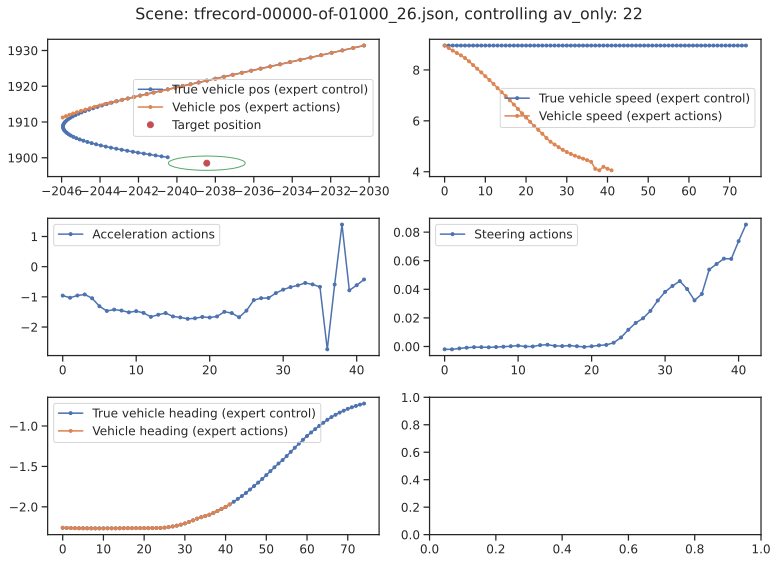

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(11, 8))
fig.suptitle(f'Scene: {scene_name}, controlling av_only: {veh_obj.id}')

# Your existing code for plotting vehicle positions and target position
axs[0, 0].plot(pos[:t_done, 0], pos[:t_done, 1], '.-', label='True vehicle pos (expert control)')
axs[0, 0].plot(pos_exp[:t_done_exp, 0], pos_exp[:t_done_exp, 1], '.-', label='Vehicle pos (expert actions)')
axs[0, 0].plot(veh_obj.target_position.x, veh_obj.target_position.y, 'ro', label='Target position')
target_position = (veh_obj.target_position.x, veh_obj.target_position.y)
circle = plt.Circle(target_position, 2, color='g', fill=False)
axs[0, 0].add_patch(circle)
axs[0, 0].legend()

# Plot speed
axs[0, 1].plot(speed[:t_done], '.-', label='True vehicle speed (expert control)')
axs[0, 1].plot(speed_exp[:t_done_exp], '.-', label='Vehicle speed (expert actions)')
axs[0, 1].legend()

# Plot acceleration
axs[1, 0].plot(action_acc_exp[:t_done_exp], '.-', label='Acceleration actions')
axs[1, 0].legend()

# Plot steering
axs[1, 1].plot(action_ste_exp[:t_done_exp], '.-', label='Steering actions')
axs[1, 1].legend()

# Plot heading
axs[2, 0].plot(heading[:t_done], '.-', label='True vehicle heading (expert control)')
axs[2, 0].plot(heading_exp[:t_done_exp], '.-', label='Vehicle heading (expert actions)')
axs[2, 0].legend()

# Set titles and labels
plt.tight_layout()